## 06_preprocessing_audio

This notebook is going to go over some ways to work with audio. As an auditory neuroscience lab, we do quite a bit with audio.

#### This notebook uses significantly more processing power / memory than previous weeks.
If you are trying to follow along at home but things are taking forever, then skip the "Extract audio from .vhdr files" and "Filtering and resampling audio" sections.

In [1]:
# will need to install this if you don't have it already
try:
    import parselmouth
except:
    !pip install praat-parselmouth
    import parselmouth

In [2]:
import mne # visualizing brain data
import numpy as np # matrix manipulation
from matplotlib import pyplot as plt # plotting
from scipy import signal # for manipulating audio
from scipy import io # for manipulating audio
from scipy.io import wavfile # for manipulating audio
import os # lets us run external programs (ie ffmpeg) from within jupyter
%matplotlib inline
# This is a module taken from https://github.com/hamiltonlabut/audio_tools
from supplemental_files import audio_tools

## Extract audio from .vhdr files
Our EEG files contain audio. This is because audio and EEG are recorded by the same device in our recording setup (This is also why we record EEG at 25kHz). However, the 25kHz EEG files with all channels are incredibly large (multiple gigabytes). For this reason we mostly work with 128Hz-downsampled files right off the bat.

In order to get a high-fidelity audio signal though, we will need to work with those 25kHz files. To offset the filesize issue, we export an EEG file at 25kHz with only one EEG channel (in addition to any relevant audio channels).

In [3]:
# Remember to change this path!
fpath = 'F:/Desktop/audio.fif'
raw = mne.io.read_raw_fif(fpath,preload=True)
print(raw.info['ch_names']) # 1 EEG, 2 audio

Opening raw data file F:/Desktop/audio.fif...
    Range : 0 ... 143928749 =      0.000 ...  5757.150 secs
Ready.


<ipython-input-3-3efdde716fcf>:3: RuntimeWarning: This filename (F:/Desktop/audio.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  raw = mne.io.read_raw_fif(fpath,preload=True)


Reading 0 ... 143928749  =      0.000 ...  5757.150 secs...
['Fp1', 'Aux1', 'Aux2']


In [4]:
# To get the audio out of the .fif format, we can convert it to a NumPy array
aud = raw.get_data(picks='Aux1').T
print(aud.shape) # That's a lot of samples!

(143928750, 1)


## Filtering and resampling audio

In [5]:
# Highpass filter at 10Hz to get rid of phase shift things that happen when recording EEG and audio
# First let's design the filter in Scipy
nyquist = 0.5 * raw.info['sfreq']
filter_freq = 10
cutoff = filter_freq/nyquist
b,a = signal.butter(5,cutoff,btype='high',analog=False)
# Apply the filter to the audio signal
aud = signal.filtfilt(b,a,aud,axis=0)

In [6]:
# After filtering we can resample our audio to 16 kHz
# This might take a while...
new_sfreq = 16000
nsamps = int(aud.shape[0]/raw.info['sfreq'])*new_sfreq
aud = signal.resample(aud, nsamps)

In [7]:
# Let's write this wavfile to your computer so we can look at it
# Change this path!
wav_fpath = 'F:/Desktop/audio.wav'
io.wavfile.write(wav_fpath,new_sfreq,aud/aud.max()) # Divide max to normalize the signal

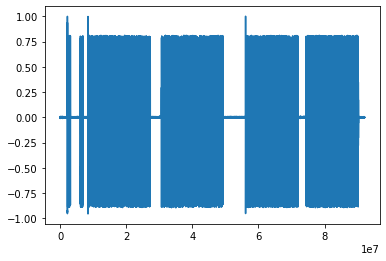

In [8]:
# Read the file we just wrote
wav = io.wavfile.read(wav_fpath)
plt.plot(wav[1]);

The filesize of this wav is incredibly large. We need to change the bitrate, and to accomplish this we are going to use a program called ffmpeg. As far as I know, this comes bundled with Anaconda. But if you try to run this and it doesn't work, here is the download page for ffmpeg: https://www.ffmpeg.org/

In [9]:
# Change bitrate to 192 kb/s
wav192_fpath = f'{wav_fpath[:-4]}_192.wav'
os.system(f'ffmpeg -i {wav_fpath} -b:a 192k {wav192_fpath}')
print("Size before resampling:", os.path.getsize(wav_fpath), 'bytes')
print("Size after resampling:", os.path.getsize(wav192_fpath), 'bytes')
# Still pretty large but hey! Better than nothing

Size before resampling: 736896058 bytes
Size after resampling: 184224078 bytes


You can use another program called sox to process your audio. I'm not going to cover it in this notebook because unless you are working with unprocessed audio straight from the EEG rig, it won't come up, and sox has a bunch of annoying system-specific requirements to install. If you find yourself in need of doing this, just message me.

I do two things in sox: highpass filtering and downsampling:
* `sox wav -r sfreq -b 16 resampled_wav`
* `sox wav resampled_wav highpass 10 -b 16`

## Extract audio envelope
Okay! If the above sections were too much for your computer, you can start following along here. We are going to use a smaller audio file to make these sections run faster.

In [10]:
# Update this fpath to the "example_audio.wav" file from Box
audio_fpath = 'F:/Desktop/example_audio.wav'
sfreq, audio = io.wavfile.read(audio_fpath)
print(sfreq)
print(audio.shape)

24000
(14520000,)


In [11]:
eeg_sfreq = 128 # We want the envelope to match the sampling rate of our eeg
envelope = audio_tools.get_envelope(audio, sfreq, eeg_sfreq)

calculating hilbert transform
Low-pass filtering hilbert transform to get audio envelope


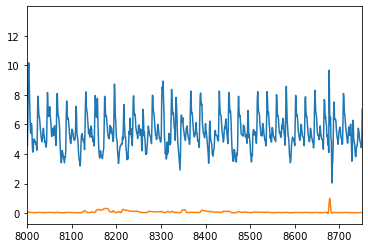

In [13]:
# Visualize envelope next to raw audio
plt.plot(signal.resample(
    audio, int(np.floor(audio.shape[0]/(sfreq/eeg_sfreq))))/signal.resample(
    audio, int(np.floor(audio.shape[0]/(sfreq/eeg_sfreq)))).max());
plt.plot(envelope/envelope.max());
plt.gca().set_xlim([8000,8750]);

## Extract spectrograms
A spectrogram is a plot of frequency over time, with the intensity at each frequency represented by how the plot is shaded. Spectrotemporal features are commonly used as inputs for the encoding/decoding models that we use in the lab.

Ok, level 2: a Mel spectrogram is a spectrogram in the Mel scale. The Mel scale is a nonlinear transformation of frequency. We do this because humans don't hear things linearly: the difference between 500 and 1000 Hz is much more perceptible to us than the difference between 5000 and 5500 Hz.


In [14]:
mel_spectrogram, freqs = audio_tools.get_mel_spectrogram(audio,sfreq)

F:\git\lab_intro_notebooks\supplemental_files\audio_tools.py:155: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  f[linpts] = f_0 + f_sp*z[linpts];
F:\git\lab_intro_notebooks\supplemental_files\audio_tools.py:156: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  f[nonlinpts] = brkfrq*np.exp(np.log(logstep)*(z[nonlinpts]-brkpt));


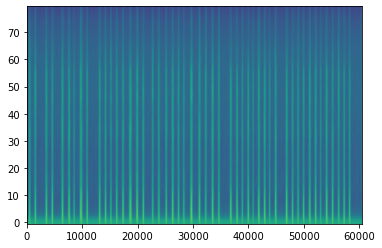

In [15]:
plt.imshow(mel_spectrogram, aspect='auto')
plt.gca().invert_yaxis();

## Extract pitch (F0)
Another common variable assessed in the lab is the pitch of a sound, which perceptually correlates with the fundamental frequency (F0).

In [16]:
pitch_values = audio_tools.get_meanF0s_v2(audio_fpath)

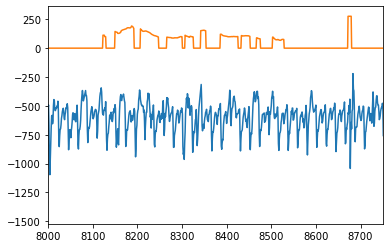

In [17]:
plt.plot(signal.resample(audio, int(np.floor(audio.shape[0]/(sfreq/eeg_sfreq)))));
plt.plot(pitch_values);
plt.gca().set_xlim([8000,8750]);